In [2]:
import networkx as nx
import numpy as np
import powerlaw
import json

In [3]:
# Load gml file
G = nx.read_gml("../data/mention_network_earliest.gml")

In [4]:
# Compute the average, median, mode, minimum and maximum value of the in-degree and out-degree
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

avg_in_degree = sum(in_degrees) / len(in_degrees)
avg_out_degree = sum(out_degrees) / len(out_degrees)
median_in_degree = np.median(in_degrees)
median_out_degree = np.median(out_degrees)
min_in_degree = min(in_degrees)
min_out_degree = min(out_degrees)
max_in_degree = max(in_degrees)
max_out_degree = max(out_degrees)

print("In-Degree statistics:")
print("---------------------")
print(f"Average: {avg_in_degree}")
print(f"Median: {median_in_degree}")
print(f"Minimum: {min_in_degree}")
print(f"Maximum: {max_in_degree}\n")

print("Out-Degree statistics:")
print("----------------------")
print(f"Average: {avg_out_degree}")
print(f"Median: {median_out_degree}")
print(f"Minimum: {min_out_degree}")
print(f"Maximum: {max_out_degree}")


In-Degree statistics:
---------------------
Average: 14.113490364025695
Median: 4.0
Minimum: 0
Maximum: 293

Out-Degree statistics:
----------------------
Average: 14.113490364025695
Median: 11.0
Minimum: 0
Maximum: 72


In [5]:
# print the streamers with highest in-degrees and out-degrees
sorted_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
sorted_out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)

print("\nTop 5 Streamers by In-Degree:")
print("-----------------------------")
for i, (streamer, degree) in enumerate(sorted_in_degrees[:5]):
    print(f"{i+1}. {streamer}: {degree}")

print("\nTop 5 Streamers by Out-Degree:")
print("------------------------------")
for i, (streamer, degree) in enumerate(sorted_out_degrees[:5]):
    print(f"{i+1}. {streamer}: {degree}")


Top 5 Streamers by In-Degree:
-----------------------------
1. smoke: 293
2. bugs: 215
3. ninja: 213
4. halo: 164
5. xqc: 150

Top 5 Streamers by Out-Degree:
------------------------------
1. yourragegaming: 72
2. erobb221: 69
3. fandy: 69
4. xqc: 65
5. zackrawrr: 62


#### Powerlaw
Power laws indicate whether a system is highly unequal: most nodes have few connections, while a small number act as hubs. Detecting a power law helps reveal if the network’s structure is shaped by self-reinforcing dynamics such as preferential attachment.

In [6]:
# Fit powerlaw distributions to in-degrees, out-degrees, and total degrees
total_degrees = in_degrees + out_degrees
fit_total = powerlaw.Fit(total_degrees, discrete=True)
fit_in = powerlaw.Fit(in_degrees, discrete=True)
fit_out = powerlaw.Fit(out_degrees, discrete=True)

print("\nPowerlaw Fit Results:")
print("---------------------")
print(f"Total Degrees: alpha = {fit_total.alpha:.4f}, xmin = {fit_total.xmin}")
print(f"In-Degrees: alpha = {fit_in.alpha:.4f}, xmin = {fit_in.xmin}")
print(f"Out-Degrees: alpha = {fit_out.alpha:.4f}, xmin = {fit_out.xmin}")

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit



Powerlaw Fit Results:
---------------------
Total Degrees: alpha = 2.7305, xmin = 20.0
In-Degrees: alpha = 2.1021, xmin = 19.0
Out-Degrees: alpha = 3.6945, xmin = 20.0


c:\Users\Andreas\miniconda3\envs\socialgraphs\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
c:\Users\Andreas\miniconda3\envs\socialgraphs\Lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


For the total degree, we find an exponent of $γ ≈ 2.83,$ which lies within the classic scale-free regime $2 < \gamma < 3$. Networks in this range naturally form hubs: a small number of streamers become globally central and are referenced frequently, while the majority have relatively modest degree. This indicates that attention on Twitch is not evenly distributed but is concentrated around a few key streamers.



For the in-degree, the exponent is $γ ≈ 1.81$, which is even lower than what is typically observed in social or information networks. Exponents below 2 indicate an extremely heavy-tailed distribution, meaning the network is dominated by a few very large hubs. In this case, a small group of streamers receives a disproportionately large share of all mentions. Such a low exponent strongly suggests preferential attachment is unusually pronounced: the more a streamer is mentioned, the more likely they are to be mentioned again. This is a clear example of a rich-get-richer or popularity-driven dynamic.



In contrast, the out-degree has an exponent of $γ ≈ 3.9$, which is relatively steep. Exponents above 3 imply that hubs are essentially absent in the outgoing direction. This means most streamers’ chats mention only a small number of other streamers, and very few mention many others. Out-degree is therefore not heavy-tailed, reflecting that chat discussions tend to focus on a limited set of other streamers and do not produce large broadcaster-like “outgoing hubs.”



The strong asymmetry between in-degree and out-degree likely reflects how attention flows on Twitch. A few streamers are mentioned far more than others because their names are frequently brought up on-stream, amplified by chat reactions, collaborations, etc.

#### Lenght of chats

We also examine the lenght of the chats. There are two questions of interest:

1. Total number of messages logged for that channel during the window.

2. Average number of words/characters per message

In [7]:
# Find the number of messeage for each streamer (node)
files_dir = "../Proj3/mention_network_chats/"
import glob
import os

message_counts = {}
word_counts = {}
for node in G.nodes():
    pattern = os.path.join(files_dir, f"{node.capitalize()}_*.json")
    matches = glob.glob(pattern)
    if len(matches) == 0:
        pattern = os.path.join(files_dir, f"{node}_*.json") 
        matches = glob.glob(pattern)
    try:
        with open(matches[0], 'r', encoding='utf-8') as f:
            data = json.load(f)
    except (IndexError, FileNotFoundError, json.JSONDecodeError):
        print(f"Could not find or open file for node: {node}")
        continue

    messages = data.get('comments', [])  # Adjusted to 'comments' based on typical Twitch chat JSON structure
    message_counts[node] = len(messages)
    # avaerage word count per message
    word_counts[node] = sum(len(message.get('message', '').get("body", "").split()) for message in messages) / len(messages) if len(messages) > 0 else 0


Could not find or open file for node: caedrel
Could not find or open file for node: jasontheween
Could not find or open file for node: zackrawrr
Could not find or open file for node: stableronaldo
Could not find or open file for node: caseoh_
Could not find or open file for node: lacy
Could not find or open file for node: shroud
Could not find or open file for node: hasanabi
Could not find or open file for node: riotgames
Could not find or open file for node: jynxzi
Could not find or open file for node: yourragegaming
Could not find or open file for node: ohnepixel
Could not find or open file for node: adapt
Could not find or open file for node: xqc
Could not find or open file for node: summit1g
Could not find or open file for node: n3on
Could not find or open file for node: aminematue
Could not find or open file for node: plaqueboymax
Could not find or open file for node: eslcs
Could not find or open file for node: theburntpeanut
Could not find or open file for node: lirik
Could not f

In [8]:
print("\nTop 5 Streamers by Message Count:")
print("-------------------------------")
sorted_message_counts = sorted(message_counts.items(), key=lambda x: x[1], reverse=True)
for i, (streamer, count) in enumerate(sorted_message_counts[:5]):
    print(f"{i+1}. {streamer}: {count} messages")

print("\nTop 5 Streamers by Average Word Count:")
print("-----------------------------")
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
for i, (streamer, count) in enumerate(sorted_word_counts[:5]):
    print(f"{i+1}. {streamer}: {count:.2f} words")


Top 5 Streamers by Message Count:
-------------------------------

Top 5 Streamers by Average Word Count:
-----------------------------


In [9]:
import networkx as nx
from scipy.stats import spearmanr # Using spearmanr
import numpy as np

# 1. Filter and Align Data
in_degrees_filtered = []
out_degrees_filtered = []
message_counts_filtered = []

# Iterate through all nodes to build aligned, filtered lists
for node in G.nodes():
    msg_count = message_counts.get(node, 0)
    
    # Only include nodes that had actual chat data (Message_Count > 0)
    if msg_count > 0:
        in_degrees_filtered.append(G.in_degree(node))
        out_degrees_filtered.append(G.out_degree(node))
        message_counts_filtered.append(msg_count)

# 2. Calculate Spearman Correlation
rho_in_corr_mc, _ = spearmanr(in_degrees_filtered, message_counts_filtered)
rho_out_corr_mc, _ = spearmanr(out_degrees_filtered, message_counts_filtered)

print("\n--- Spearman Correlation (Volume Analysis) ---")
print("In-Degree vs. Message Count: {:.4f})".format(rho_in_corr_mc))
print("Out-Degree vs. Message Count: {:.4f})".format(rho_out_corr_mc))


--- Spearman Correlation (Volume Analysis) ---
In-Degree vs. Message Count: nan)
Out-Degree vs. Message Count: nan)


In [10]:
# 1. Filter and Align Data
in_degrees_filtered = []
out_degrees_filtered = []
word_counts_filtered = []

# Iterate through all nodes to build aligned, filtered lists
for node in G.nodes():
    avg_wc = word_counts.get(node, 0)
    
    # Only include nodes that had valid chat data (Avg_Word_Count > 0)
    if avg_wc > 0:
        in_degrees_filtered.append(G.in_degree(node))
        out_degrees_filtered.append(G.out_degree(node))
        word_counts_filtered.append(avg_wc)

# 2. Calculate Spearman Correlation
rho_in_corr_wc, _ = spearmanr(in_degrees_filtered, word_counts_filtered)
rho_out_corr_wc, _ = spearmanr(out_degrees_filtered, word_counts_filtered)
print("\n--- Spearman Correlation (Linguistic Analysis) ---")
print("In-Degree vs. Avg Word Count: {:.4f}".format(rho_in_corr_wc))
print("Out-Degree vs. Avg Word Count: {:.4f}".format(rho_out_corr_wc))


--- Spearman Correlation (Linguistic Analysis) ---
In-Degree vs. Avg Word Count: nan
Out-Degree vs. Avg Word Count: nan


Analyzing the correlations we see a strong positive correlation between Out-Degree and Message Count ($\rho \approx +0.68$). It confirms that the activity and scale (Volume) is the primary driver of a streamer's outgoing influence (Out-Degree) within the network. Streamers with the highest volume are the most connected and active hubs in the network. Furthermore, for the lingustic analysis, both correlations are negative, this suggest that network centrality inversely correlates with linguistic complexity. As a streamer's influence (especially Out-Degree, $\rho \approx -0.36$) increases, the average word count in their chat decreases. This suggests that the streams acting as major hubs and bridges in the network tend to foster simplistic, rapid-fire communication, indicating that broad structural influence comes at the cost of verbose discussion. 

#### Centrality

##### Betweenness Centrality

In [11]:
# Find the betweenness centrality for each node in the directed graph
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# Is there a correlation between betweenness centrality and message count or average word count?
betweenness_filtered = []
message_counts_filtered = []
word_counts_filtered = []
for node in G.nodes():
    msg_count = message_counts.get(node, 0)
    avg_wc = word_counts.get(node, 0)
    
    # Only include nodes that had actual chat data (Message_Count > 0)
    if msg_count > 0:
        betweenness_filtered.append(betweenness_centrality[node])
        message_counts_filtered.append(msg_count)
        word_counts_filtered.append(avg_wc)

# Calculate Spearman Correlation
rho_betweenness_corr_mc, _ = spearmanr(betweenness_filtered, message_counts_filtered)
rho_betweenness_corr_wc, _ = spearmanr(betweenness_filtered, word_counts_filtered)

print("\n--- Betweenness Centrality Correlations ---")
print("Betweenness Centrality vs. Message Count: {:.4f}".format(rho_betweenness_corr_mc))
print("Betweenness Centrality vs. Avg Word Count: {:.4f}".format(rho_betweenness_corr_wc))


--- Betweenness Centrality Correlations ---
Betweenness Centrality vs. Message Count: nan
Betweenness Centrality vs. Avg Word Count: nan


We see a positve correlation with betweeness Centrality and message count and a negative correlation with the average word count, suggesting the streamers with the greatest structural importance for the cohesion of the Twitch network (high Betweenness Centrality) are characterized by high volume of messages and low linguistic complexity. They function as busy, easily accessible hubs that enable fast and simple information exchange.

##### Eigenvector Centrality

In [12]:
# Fined the eigenvector centrality for each node in the directed graph
eigenvector_centrality = nx.eigenvector_centrality(G)

# Is there a correlation between eigenvector centrality and message count or average word count?
eigenvector_filtered = []
message_counts_filtered = []
word_counts_filtered = []
for node in G.nodes():
    msg_count = message_counts.get(node, 0)
    avg_wc = word_counts.get(node, 0)
    
    # Only include nodes that had actual chat data (Message_Count > 0)
    if msg_count > 0:
        eigenvector_filtered.append(eigenvector_centrality[node])
        message_counts_filtered.append(msg_count)
        word_counts_filtered.append(avg_wc)

# Calculate Spearman Correlation
rho_eigenvector_corr_mc, _ = spearmanr(eigenvector_filtered, message_counts_filtered)
rho_eigenvector_corr_wc, _ = spearmanr(eigenvector_filtered, word_counts_filtered)
print("\n--- Eigenvector Centrality Correlations ---")
print("Eigenvector Centrality vs. Message Count: {:.4f}".format(rho_eigenvector_corr_mc))
print("Eigenvector Centrality vs. Avg Word Count: {:.4f}".format(rho_eigenvector_corr_wc))


--- Eigenvector Centrality Correlations ---
Eigenvector Centrality vs. Message Count: nan
Eigenvector Centrality vs. Avg Word Count: nan


#### Shortest Path

In [13]:
# Find the strongly connected components
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len)
G_scc = G.subgraph(largest_scc)

aspl_twitch = nx.average_shortest_path_length(G_scc)

print(f"Twitch shortest path: {aspl_twitch:.4f}")

Twitch shortest path: 3.0157


In [14]:
# Generate a random graph with the same number of nodes and edges
N = G_scc.number_of_nodes()
p = nx.density(G_scc)


G_rand = nx.gnp_random_graph(N, p, directed=True)
aspl_rand = nx.average_shortest_path_length(G_rand)
print(f"Random Graph shortest path: {aspl_rand:.4f}")

Random Graph shortest path: 2.4240


Text(0, 0.5, 'Frequency')

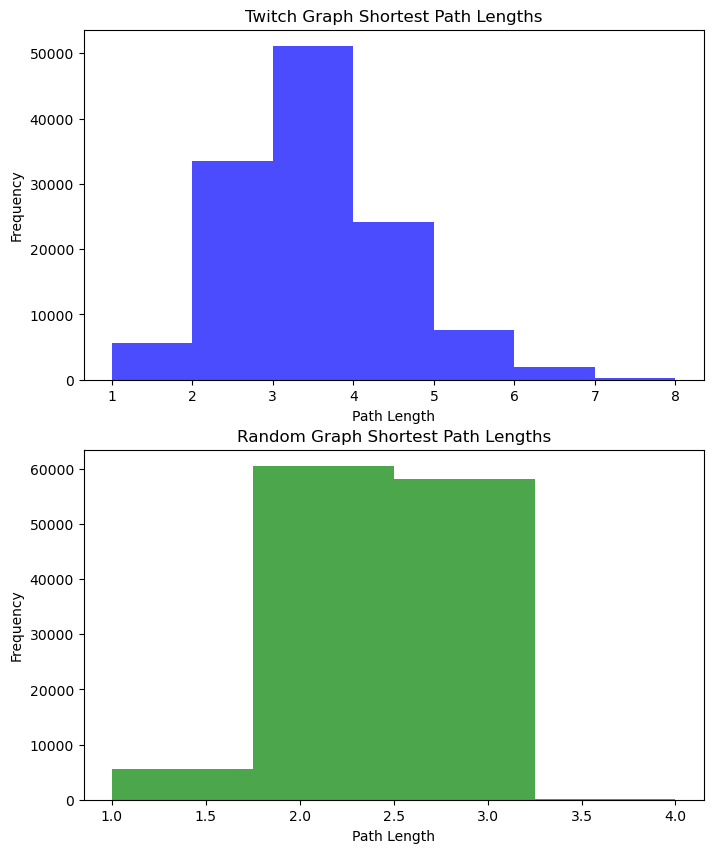

In [15]:
# Plot the shortest path distributions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Twitch graph shortest path lengths
lengths_twitch = dict(nx.all_pairs_shortest_path_length(G_scc))
path_lengths_twitch = []
for source in lengths_twitch:
    for target in lengths_twitch[source]:
        if source != target:
            path_lengths_twitch.append(lengths_twitch[source][target])

ax[0].hist(path_lengths_twitch, bins=7, color='blue', alpha=0.7)
ax[0].set_title('Twitch Graph Shortest Path Lengths')
ax[0].set_xlabel('Path Length')
ax[0].set_ylabel('Frequency')

# Random graph shortest path lengths
lengths_rand = dict(nx.all_pairs_shortest_path_length(G_rand))
path_lengths_rand = []
for source in lengths_rand:
    for target in lengths_rand[source]:
        if source != target:
            path_lengths_rand.append(lengths_rand[source][target])  

ax[1].hist(path_lengths_rand, bins=4, color='green', alpha=0.7)
ax[1].set_title('Random Graph Shortest Path Lengths')
ax[1].set_xlabel('Path Length')
ax[1].set_ylabel('Frequency')



#### Communities

First we find the partitions

In [16]:
from community import community_louvain # from the python-louvain library

G_undir = G.to_undirected()
partition = community_louvain.best_partition(G_undir)
modularity = community_louvain.modularity(partition, G_undir)


print("\n--- Community Detection ---")
print(f"Modularity Score (Q): {modularity:.4f}")
print(f"Number of Communities Detected: {len(set(partition.values()))}")


--- Community Detection ---
Modularity Score (Q): 0.6373
Number of Communities Detected: 20


Next we find some statistics for the communities

Average Community Size: 23.35
Median Community Size: 11.00
Minimum Community Size: 1
Maximum Community Size: 125
number of communities with size 1: 6


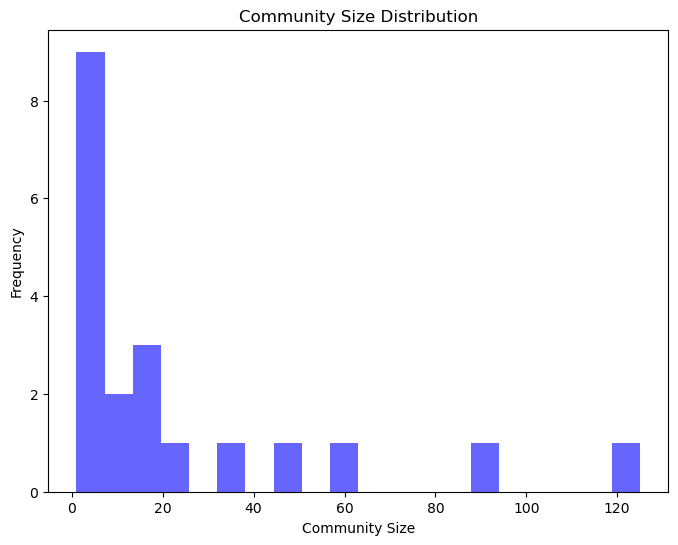

In [17]:
# community statistics

community_sizes = {}
for comm in set(partition.values()):
    community_sizes[comm] = list(partition.values()).count(comm)
size_values = list(community_sizes.values())
print(f"Average Community Size: {np.mean(size_values):.2f}")
print(f"Median Community Size: {np.median(size_values):.2f}")
print(f"Minimum Community Size: {np.min(size_values)}")
print(f"Maximum Community Size: {np.max(size_values)}")
print(f"number of communities with size 1: {list(size_values).count(1)}")

# Plot community size distribution
plt.figure(figsize=(8, 6))
plt.hist(size_values, bins=20, color='blue', alpha=0.6)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.show()

From the communities we can see a high modularity score, which indicates a strong membership structure, meaning the top twitch streamers show strong and robust clustering which is not random. This means similar streamers tend to link to eachother. However, 33 of the 47 communities only have one member and are isolates. 

Next lets look at the lingustics are in the communities of the top 5 largest communities

In [18]:
# select a few communities to analyze linguistics
selected_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:12]  # Select the 5 largest communities

# print the top most connected nodes in each community
for comm in selected_communities:
    members = [node for node in partition if partition[node] == comm]
    subgraph = G_undir.subgraph(members)
    degrees = subgraph.degree()
    sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
    print(f"\nCommunity {comm} (Size: {community_sizes[comm]}):")
    print("Top 5 Most Connected Streamers:")
    for i, (streamer, degree) in enumerate(sorted_degrees[:10]):
        print(f"{i+1}. {streamer}: {degree} connections")



Community 8 (Size: 125):
Top 5 Most Connected Streamers:
1. bugs: 77 connections
2. vegas: 52 connections
3. chess: 47 connections
4. peter: 44 connections
5. bean: 43 connections
6. maximum: 42 connections
7. tomato: 34 connections
8. warn: 30 connections
9. northernlion: 24 connections
10. ludwig: 24 connections

Community 0 (Size: 88):
Top 5 Most Connected Streamers:
1. fandy: 61 connections
2. forsen: 50 connections
3. xqc: 47 connections
4. penta: 37 connections
5. mizkif: 34 connections
6. erobb221: 27 connections
7. lacari: 26 connections
8. caedrel: 25 connections
9. emiru: 24 connections
10. extraemily: 23 connections

Community 9 (Size: 61):
Top 5 Most Connected Streamers:
1. smoke: 54 connections
2. ohnepixel: 19 connections
3. tenz: 16 connections
4. tarik: 15 connections
5. s0mcs: 13 connections
6. demon1: 12 connections
7. august: 11 connections
8. aceu: 11 connections
9. mooda: 11 connections
10. shanks_ttv: 10 connections

Community 3 (Size: 50):
Top 5 Most Connected S

In [19]:
# print the average word count for the top 5 largest communitiesfor comm in selected_communities:

selected_communities_members = {comm: [node for node in partition if partition[node] == comm] for comm in selected_communities}


print("\n--- Linguistic Analysis of Selected Communities ---")
for comm, members in selected_communities_members.items():
    avg_word_count = np.mean([word_counts.get(node, 0) for node in members if word_counts.get(node, 0) > 0])
    print(f"\nCommunity {comm} (Size: {community_sizes[comm]}):")
    print(f"Average Word Count: {avg_word_count:.2f}")



--- Linguistic Analysis of Selected Communities ---

Community 8 (Size: 125):
Average Word Count: nan

Community 0 (Size: 88):
Average Word Count: nan

Community 9 (Size: 61):
Average Word Count: nan

Community 3 (Size: 50):
Average Word Count: nan

Community 6 (Size: 37):
Average Word Count: nan

Community 1 (Size: 25):
Average Word Count: nan

Community 15 (Size: 16):
Average Word Count: nan

Community 4 (Size: 14):
Average Word Count: nan

Community 12 (Size: 14):
Average Word Count: nan

Community 7 (Size: 12):
Average Word Count: nan

Community 11 (Size: 10):
Average Word Count: nan

Community 10 (Size: 5):
Average Word Count: nan


c:\Users\Andreas\miniconda3\envs\socialgraphs\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Andreas\miniconda3\envs\socialgraphs\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Analyzing the linguistics of the selected communities, reveals that the Twitch elite is polarized into distinct "Chat Cultures": Conversational Clusters (e.g., Comm 12): Characterized by higher word counts, suggesting a norm of discussion and sentence-based communication. Reactionary Clusters (e.g., Comm 1): Characterized by low word counts, suggesting a norm of "reactionary" chat (emotes, rapid-fire slang, short phrases). This again suggest that streamers link to others who share their specific communicative norms.

In [20]:
# Save the communities to a JSON file
community_data = {
    'partition': partition,
    'modularity': modularity,
    'num_communities': len(set(partition.values())),
    'community_sizes': community_sizes
}

with open(os.path.join("..", "data", 'communities.json'), 'w', encoding='utf-8') as f:
    json.dump(community_data, f, indent=4)

print("Communities saved to communities.json")

Communities saved to communities.json
